Install dependencies if not already installed

In [16]:
#!pip install GEOparse pandas matplotlib numpy pyDESeq2

## 1. Import Libraries

In [17]:
import GEOparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

## 2. Download the GEO dataset

In [18]:
# Replace with your GEO accession
gse_id ="GSE268683"
gse = GEOparse.get_GEO(gse_id, destdir="./data")

05-Oct-2025 20:04:46 DEBUG utils - Directory ./data already exists. Skipping.
05-Oct-2025 20:04:46 INFO GEOparse - File already exist: using local version.
05-Oct-2025 20:04:46 INFO GEOparse - Parsing ./data\GSE268683_family.soft.gz: 
05-Oct-2025 20:04:46 DEBUG GEOparse - DATABASE: GeoMiame
05-Oct-2025 20:04:46 DEBUG GEOparse - SERIES: GSE268683
05-Oct-2025 20:04:46 DEBUG GEOparse - PLATFORM: GPL34537
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296406
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296407
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296408
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296409
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296410
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296411
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296412
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296413
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296414
05-Oct-2025 20:04:46 DEBUG GEOparse - SAMPLE: GSM8296415
05-Oct-2025 20:04:46 DEBU

In [19]:
print(f"Dataset: {gse_id}")
print(f"Title: {gse.metadata['title'][0]}")
print(f"Samples: {len(gse.gsms)}")

Dataset: GSE268683
Title: Music elicits different gene expression responses in the buccal cavity of age-related cognitive disorders patients and healthy controls.
Samples: 48


## 3. Extract expression data

Expression Matrix is a table where rows are genes and columns are samples (like different patients or conditions). The values are the raw read counts (for RNA-seq) or expression levels.

In [20]:
#  Pivot samples to get genes as rows, samples as columns
expression_data = gse.pivot_samples(values='VALUE')

In [21]:
print("Shape of expression_data:",expression_data.shape)

Shape of expression_data: (785, 48)


In [22]:
expression_data.head()

name,GSM8296406,GSM8296407,GSM8296408,GSM8296409,GSM8296410,GSM8296411,GSM8296412,GSM8296413,GSM8296414,GSM8296415,...,GSM8296444,GSM8296445,GSM8296446,GSM8296447,GSM8296448,GSM8296449,GSM8296450,GSM8296451,GSM8296452,GSM8296453
ID_REF,,,,,,,,,,,,,,,,,,,,,
ABCF1,29,17,35,24,68,23,41,24,114,47,...,127,200,8,27,211,20,76,22,52,67
ACE,12,12,10,9,9,6,11,8,9,5,...,8,14,10,4,7,9,14,10,10,10
ACKR2,12,7,6,7,17,4,17,15,47,13,...,41,42,3,4,51,3,28,17,37,13
ACKR3,35,17,15,20,60,27,20,14,264,69,...,40,38,15,14,99,15,25,30,185,184
ACKR4,11,7,4,8,18,3,9,7,10,13,...,14,12,7,4,9,12,7,6,14,10


## 4. Build Metadata Table

Metadata is a table with information about each sample, such as the experimental condition (e.g., 'Treated' vs. 'Control'), age, tissue type, etc. This info is critical for differential expression analysis.

In [23]:
#  Extract sample info
metadata = gse.phenotype_data
metadata.head()

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,...,contact_department,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,series_id,data_row_count
GSM8296406,B4470-1,GSM8296406,Public on Sep 10 2025,May 30 2024,Sep 10 2025,RNA,1,Saliva,Homo sapiens,9606,...,Pediatrics,GENVIP research group,Choupana sn,Santiago de Compostela,A coruÃ±a,15706,Spain,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8296...,GSE268683,785
GSM8296407,B4470-2,GSM8296407,Public on Sep 10 2025,May 30 2024,Sep 10 2025,RNA,1,Saliva,Homo sapiens,9606,...,Pediatrics,GENVIP research group,Choupana sn,Santiago de Compostela,A coruÃ±a,15706,Spain,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8296...,GSE268683,785
GSM8296408,1006-1,GSM8296408,Public on Sep 10 2025,May 30 2024,Sep 10 2025,RNA,1,Saliva,Homo sapiens,9606,...,Pediatrics,GENVIP research group,Choupana sn,Santiago de Compostela,A coruÃ±a,15706,Spain,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8296...,GSE268683,785
GSM8296409,1006-2,GSM8296409,Public on Sep 10 2025,May 30 2024,Sep 10 2025,RNA,1,Saliva,Homo sapiens,9606,...,Pediatrics,GENVIP research group,Choupana sn,Santiago de Compostela,A coruÃ±a,15706,Spain,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8296...,GSE268683,785
GSM8296410,1007-1,GSM8296410,Public on Sep 10 2025,May 30 2024,Sep 10 2025,RNA,1,Saliva,Homo sapiens,9606,...,Pediatrics,GENVIP research group,Choupana sn,Santiago de Compostela,A coruÃ±a,15706,Spain,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8296...,GSE268683,785


In [24]:
# Finding the unique values 
metadata['characteristics_ch1.0.phenotype'].value_counts()

characteristics_ch1.0.phenotype
CONTROL    28
ACD        20
Name: count, dtype: int64

In [25]:
# Keep only condition
metadata_df = metadata[['characteristics_ch1.0.phenotype']]
metadata_df = metadata_df.rename(columns={'characteristics_ch1.0.phenotype': 'Condition'})
metadata_df.head()

,Condition
GSM8296406,ACD
GSM8296407,ACD
GSM8296408,ACD
GSM8296409,ACD
GSM8296410,CONTROL


## 5. Run pyDESeq2 Analysis

In [26]:
# Transpose expression data so samples = rows, genes = columns
counts_for_deseq = expression_data.transpose()

# Reorder counts rows to match metadata
counts_for_deseq = counts_for_deseq.loc[metadata_df.index]

In [27]:
# Create DESeq2 dataset
dds = DeseqDataSet(
counts=counts_for_deseq,
metadata=metadata_df,
design="Condition"
)

# Run DESeq2 analysis
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.55 seconds.

Fitting dispersion trend curve...
C:\Users\cinta\anaconda3\envs\py310\lib\site-packages\pydeseq2\dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.60 seconds.

Fitting LFCs...
... done in 0.34 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 29 outlier genes.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.04 seconds.



## 6. Extract differential expression results

In [28]:
# Run statistical test - Specify which group vs which group
stats = DeseqStats(dds, contrast=["Condition", "ACD", "CONTROL"]) # adjust group names if needed
stats.summary()

# Get results as a DataFrame
deg_results = stats.results_df

Running Wald tests...
... done in 0.15 seconds.



Log2 fold change & Wald test p-value: Condition ACD vs CONTROL
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
ID_REF                                                                    
ABCF1    36.297311        0.512575  0.293662  1.745457  0.080905  0.137190
ACE       9.155262        0.761077  0.270871  2.809743  0.004958  0.016492
ACKR2    10.209533        0.782365  0.296380  2.639734  0.008297  0.024123
ACKR3    27.384326        1.069658  0.314856  3.397297  0.000681  0.003318
ACKR4     7.588003        0.608041  0.254895  2.385459  0.017058  0.041075
...            ...             ...       ...       ...       ...       ...
XCL1/2    8.815814        0.086213  0.317452  0.271577  0.785947  0.837135
XCR1     11.420863        0.333503  0.244239  1.365477  0.172103  0.248347
YWHAQ   322.091948        1.150046  0.336302  3.419685  0.000627  0.003177
ZAP70     7.887914        0.150312  0.263892  0.569596  0.568952  0.649894
ZBP1     49.913058       -1.042558  0

## 7. Filter significant DEGs

In [29]:
# Define significance
deg_results['significant'] = (deg_results['padj'] < 0.05) & (abs(deg_results['log2FoldChange']) > 1)

# Filter significant DEGs
sig_genes = deg_results[deg_results['significant']]

# Upregulated and downregulated 
up = sig_genes[sig_genes['log2FoldChange'] > 0]
down = sig_genes[sig_genes['log2FoldChange'] < 0]

# Save
sig_genes.reset_index(inplace=True)  # move index to a column
sig_genes.to_csv("DEG_results.csv", index=False)

print(f"Significant genes: {len(sig_genes)} (Up: {len(up)}, Down: {len(down)})")

Significant genes: 166 (Up: 56, Down: 110)


## 8. Visualize DEGs (Volcano Plot)

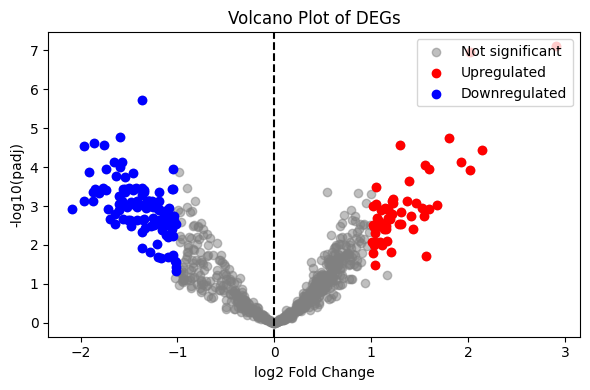

In [30]:
plt.figure(figsize=(6,4))

# All genes in gray
plt.scatter(deg_results['log2FoldChange'], -np.log10(deg_results['padj']),
            color='gray', alpha=0.5,label='Not significant')

# Upregulated in red
plt.scatter(up['log2FoldChange'], -np.log10(up['padj']),
            color='red', label='Upregulated')

# Downregulated in blue
plt.scatter(down['log2FoldChange'], -np.log10(down['padj']),
            color='blue', label='Downregulated')

# Vertical line at 0
plt.axvline(0, color='black', linestyle='--')

# Labels and title
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(padj)')
plt.title('Volcano Plot of DEGs')

#Legend
plt.legend(loc='upper right')

# Save and show
plt.tight_layout()
plt.savefig("volcano_plot.png", dpi=150)
plt.show()